In [21]:
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
#from sklearn import datasets, metrics, tree
from graphviz import Source
import subprocess
from os import system
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [22]:
organics_data = pd.read_csv(r'..\..\..\datasets\ORGANICS.csv')
organics_data.head()

,ID,DemAffl,DemAge,DemCluster,DemClusterGroup,DemGender,DemReg,DemTVReg,PromClass,PromSpend,PromTime,TargetBuy,TargetAmt
0,140,10.0,76.0,16.0,C,U,Midlands,Wales & West,Gold,16000.00,4.0,0,0
1,620,4.0,49.0,35.0,D,U,Midlands,Wales & West,Gold,6000.00,5.0,0,0
2,868,5.0,70.0,27.0,D,F,Midlands,Wales & West,Silver,0.02,8.0,1,1
3,1120,10.0,65.0,51.0,F,M,Midlands,Midlands,Tin,0.01,7.0,1,1
4,2313,11.0,68.0,4.0,A,F,Midlands,Midlands,Tin,0.01,8.0,0,0


* **ID** - идентификационный номер лояльности клиентов
* **DemAffl** - оценка достатка по шкале от 1 до 30 (1 = наименее обеспеченный, 30 = наиболее обеспеченный)
* **DemAge** - возраст
* **DemCluster** - идентификатор жилого микрорайона
* **DemClusterGroup** - множество похожих кварталов (A-F = тип окрестности, U = неизвестно)
* **DemGender** - M = мужчина, F = женщина, U = неизвестно
* **DemReg** - географический регион
* **DemTVReg** - регион телевещания
* **PromClass** - статус лояльности: олово, серебро, золото или платина
* **PromSpend** - общая сумма потраченных средств (в британских фунтах стерлингов)
* **PromTime** - срок участия в программе лояльности
* **TargetBuy** - приобретен ли продукт? 1 = Да, 0 = Нет
* **TargetAmt** - Количество приобретенных продуктов

### 1. Вывести данные, описательную статистику , проверить корреляции между признаками. 

In [23]:
print(organics_data.shape)
print(organics_data.info())

(22223, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 13 columns):
ID                 22223 non-null int64
DemAffl            21138 non-null float64
DemAge             20715 non-null float64
DemCluster         21549 non-null float64
DemClusterGroup    21549 non-null object
DemGender          19711 non-null object
DemReg             21758 non-null object
DemTVReg           21758 non-null object
PromClass          22223 non-null object
PromSpend          22223 non-null float64
PromTime           21942 non-null float64
TargetBuy          22223 non-null int64
TargetAmt          22223 non-null int64
dtypes: float64(5), int64(3), object(5)
memory usage: 2.2+ MB
None


#### 1) Заполняем значения `nul`l: берем моду по числовому значению, и в пусты строки добавляем средние значения. Удаляем столбцы 'TargetAmt', 'DemClusterGroup'

In [24]:
organics_data = organics_data.fillna(organics_data.mode().iloc[0])
organics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22223 entries, 0 to 22222
Data columns (total 13 columns):
ID                 22223 non-null int64
DemAffl            22223 non-null float64
DemAge             22223 non-null float64
DemCluster         22223 non-null float64
DemClusterGroup    22223 non-null object
DemGender          22223 non-null object
DemReg             22223 non-null object
DemTVReg           22223 non-null object
PromClass          22223 non-null object
PromSpend          22223 non-null float64
PromTime           22223 non-null float64
TargetBuy          22223 non-null int64
TargetAmt          22223 non-null int64
dtypes: float64(5), int64(3), object(5)
memory usage: 2.2+ MB


#### проверить корреляции между признаками

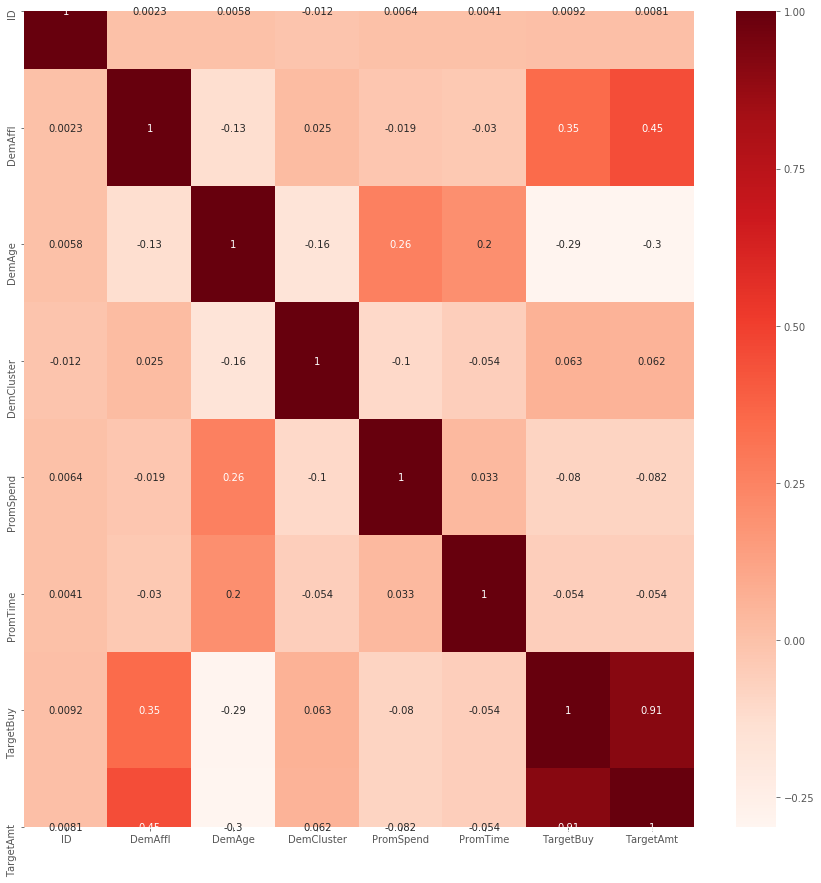

In [25]:
plt.figure(figsize=(15, 15))
correlation_matrix = organics_data.corr()  
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Reds)
plt.show()

**Коэффициент корреляции Пирсона** показывает, что есть зависимость между уровнем доходов / возрастом / полом и `TargetBuy`, а переменные `DemReg`, `DemTVReg` практически не влияют на `TargetBuy`.

#### Для анализа в этой части используем пока только количественные признаки (Affl , Age, Cluster, Promspend,PromTime)

In [26]:
x=organics_data[['DemAffl',  'DemAge', 'DemCluster', 'PromSpend', 'PromTime']]
y=organics_data.values[::,11]
y=y.astype('int')

In [27]:
x.head()

,DemAffl,DemAge,DemCluster,PromSpend,PromTime
0,10.0,76.0,16.0,16000.00,4.0
1,4.0,49.0,35.0,6000.00,5.0
2,5.0,70.0,27.0,0.02,8.0
3,10.0,65.0,51.0,0.01,7.0
4,11.0,68.0,4.0,0.01,8.0


#### Разбиение на обучение и контроль:

In [28]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

### 2. Обучение модели:

In [29]:
tree=DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

### 3.	Визуализация модели 

In [30]:
dotfile = open(r'Organics_tree.dot', 'w')

graph = Source(export_graphviz(tree, out_file=dotfile, 
               rounded = True, proportion = False, 
                precision = 2, filled = True))
dotfile.close()
system("dot -Tpng Organics_tree.dot -o Organics_tree.png")


0

### 4.	Оценка точности модели 

In [31]:
tree.score(X_train, y_train) # результат на обучающей выборке

0.8034841861661095

In [32]:
tree.score(X_test,y_test) # результат на тестовой выборке- число правильных результатов

0.8009599520023999

## DZ

### 1a. Обучите решающее дерево с параметрами `criterion = entropy` и `max_depth =5`.  Какую точность дает данное дерево на контроле? Визуализируйте разделяющую поверхность.

In [33]:
tree2=DecisionTreeClassifier(criterion='entropy',max_depth=5, random_state=0)
tree2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=0, splitter='best')

#### Определим точность данного дерева на контроле

In [34]:
accuracy_score(y_test, tree.predict(X_test))

0.8009599520023999

In [35]:
print(tree2.score(X_train, y_train)) # результат на обучающей выборке
print(tree2.score(X_test,y_test)) # результат на тестовой выборке- число правильных результатов

0.803934173309334
0.8009599520023999


#### Визуализируем разделяющую поверхность

In [36]:
# Напишем вспомогательную функцию, которая будет возвращать решетку для дальнейшей визуализации.
def get_grid(data):
    x_min, x_max = data.iloc[:, 0].min() - 1, data.iloc[:, 0].max() + 1
    y_min, y_max = data.iloc[:, 1].min() - 1, data.iloc[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
def draw_dividing_surface(tree, X_train, y_train):
    xx, yy = get_grid(X_train)
    predicted = tree.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.figure(figsize=(20,10))
    plt.pcolormesh(xx, yy, predicted, cmap='autumn')
    plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 1], c=y_train, s=100, 
    cmap='autumn', edgecolors='black', linewidth=1.5)

In [37]:
x_sur = organics_data[['DemAffl', 'PromTime']]
y_sur = organics_data.values[::,11]

X_train_sur, X_test_sur, y_train_sur, y_test_sur = train_test_split(x_sur, y_sur, test_size=0.3)
tree3 = DecisionTreeClassifier(criterion='entropy', max_depth=5)
y_train_sur = y_train_sur.astype(int)
y_test_sur = y_test_sur.astype(int)
# обучаем дерево
tree3.fit(X_train_sur, y_train_sur)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

0.7804109794510274

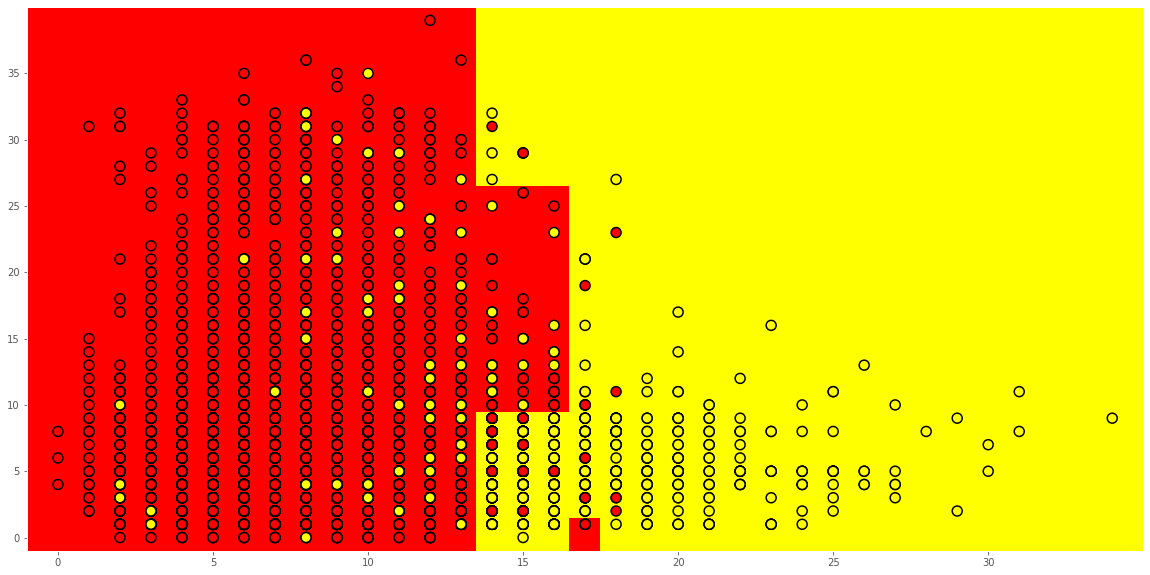

In [38]:
draw_dividing_surface(tree3, X_train_sur, y_train_sur)
accuracy_score(y_test_sur, tree3.predict(X_test_sur))

0.7970601469926504

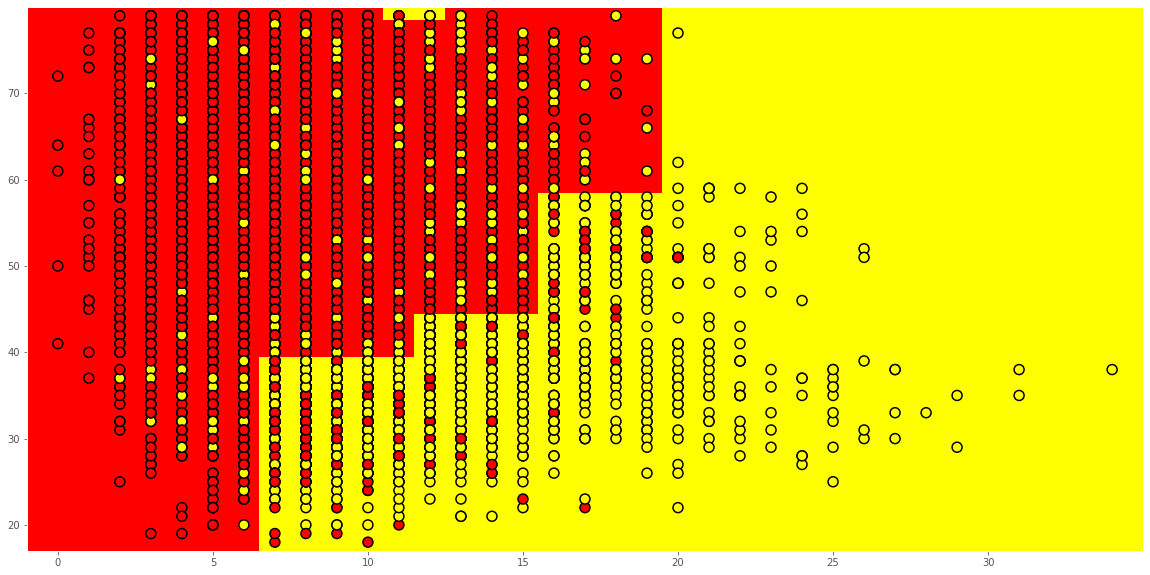

In [39]:
x_sur = organics_data[['DemAffl', 'DemAge']]
y_sur = organics_data.values[::,11]

X_train_sur, X_test_sur, y_train_sur, y_test_sur = train_test_split(x_sur, y_sur, test_size=0.3)
tree4 = DecisionTreeClassifier(criterion='entropy', max_depth=5)
y_train_sur = y_train_sur.astype(int)
y_test_sur = y_test_sur.astype(int)
# обучаем дерево
tree4.fit(X_train_sur, y_train_sur)

draw_dividing_surface(tree4, X_train_sur,y_train_sur)
accuracy_score(y_test_sur, tree4.predict(X_test_sur))

### 1b.	Выполните предыдущий пункт для разных значений глубины дерева и минимального числа объектов в листе (параметры `max_depth` и `min_samples_leaf`). Результаты запишите в виде таблицы.  Как эти параметры влияют на вид разделяющей поверхности и точность модели?

##### Проанализируем зависимость оценок в зависимости от параметра `max_depth`

In [40]:
max_depth_vals = range(1,16)

In [41]:
df = pd.DataFrame()
for max_depth in max_depth_vals:    
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    tree.fit(X_train, y_train)
    train_score = tree.score(X_train, y_train)
    acc_score = accuracy_score(y_test, tree.predict(X_test))
    
    temp_score_data = pd.DataFrame({'max_depth': [max_depth], 
                                    'train_score': train_score,
                                    'accuracy_score': acc_score})
    df = df.append(temp_score_data)
df

,max_depth,train_score,accuracy_score
0,1,0.761250,0.767212
0,2,0.787670,0.786261
0,3,0.793456,0.793010
0,4,0.803741,0.801110
0,5,0.803934,0.800960
0,6,0.806698,0.801410
0,7,0.808498,0.797660
0,8,0.813448,0.797360
0,9,0.818205,0.797660
0,10,0.824119,0.795110


Заметим, что лучшие результаты достигаются при **`max_depth = [4;6]`**

##### Проанализируем зависимость оценок от параметра `max_depth` и `min_samples_leaf`

In [42]:
max_depth_vals = range(4,7)
min_samples_leaf_vals = range(1,10)
df = pd.DataFrame()
for max_depth in max_depth_vals:
    for min_samples_leaf in min_samples_leaf_vals:
        tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, max_depth=max_depth)
        tree.fit(X_train, y_train)
        train_score = tree.score(X_train, y_train)
        acc_score = accuracy_score(y_test, tree.predict(X_test))
    
        temp_score_data = pd.DataFrame({'max_depth': [max_depth],
                                    'min_samples_leaf': [min_samples_leaf], 
                                    'train_score': train_score,
                                    'accuracy_score': acc_score})
        df = df.append(temp_score_data)
df

,max_depth,min_samples_leaf,train_score,accuracy_score
0,4,1,0.803741,0.80111
0,4,2,0.803741,0.80111
0,4,3,0.803741,0.80111
0,4,4,0.803741,0.80111
0,4,5,0.803741,0.80111
0,4,6,0.803741,0.80111
0,4,7,0.803741,0.80111
0,4,8,0.803741,0.80111
0,4,9,0.803741,0.80111
0,5,1,0.803934,0.80096


Заметим, что при **`max_depth=6`** **`accuracy_score`** выше

In [43]:
min_samples_leaf_vals = range(1,31)
df = pd.DataFrame()
for min_samples_leaf in min_samples_leaf_vals:
        tree = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=min_samples_leaf, max_depth=6)
        tree.fit(X_train, y_train)
        train_score = tree.score(X_train, y_train)
        acc_score = accuracy_score(y_test, tree.predict(X_test))
    
        temp_score_data = pd.DataFrame({'max_depth': 6,
                                    'min_samples_leaf': [min_samples_leaf], 
                                    'train_score': [train_score],
                                    'accuracy_score': [acc_score]})
        df = df.append(temp_score_data)
df

,max_depth,min_samples_leaf,train_score,accuracy_score
0,6,1,0.806698,0.80141
0,6,2,0.806634,0.80156
0,6,3,0.806634,0.80141
0,6,4,0.807084,0.79766
0,6,5,0.807084,0.79766
0,6,6,0.807277,0.79691
0,6,7,0.807277,0.79691
0,6,8,0.806956,0.79706
0,6,9,0.806827,0.79751
0,6,10,0.807020,0.79691


Таким образом наилучшая оценка достигается при параметрах **`max_depth=6`** и **`min_samples_leaf=30`**

In [44]:
x_sur = organics_data[['DemAffl', 'DemAge']]
y_sur = organics_data.values[::,11]

X_train_sur, X_test_sur, y_train_sur, y_test_sur = train_test_split(x_sur, y_sur, test_size=0.3)

Переобученное дерево:

0.7931603419829009

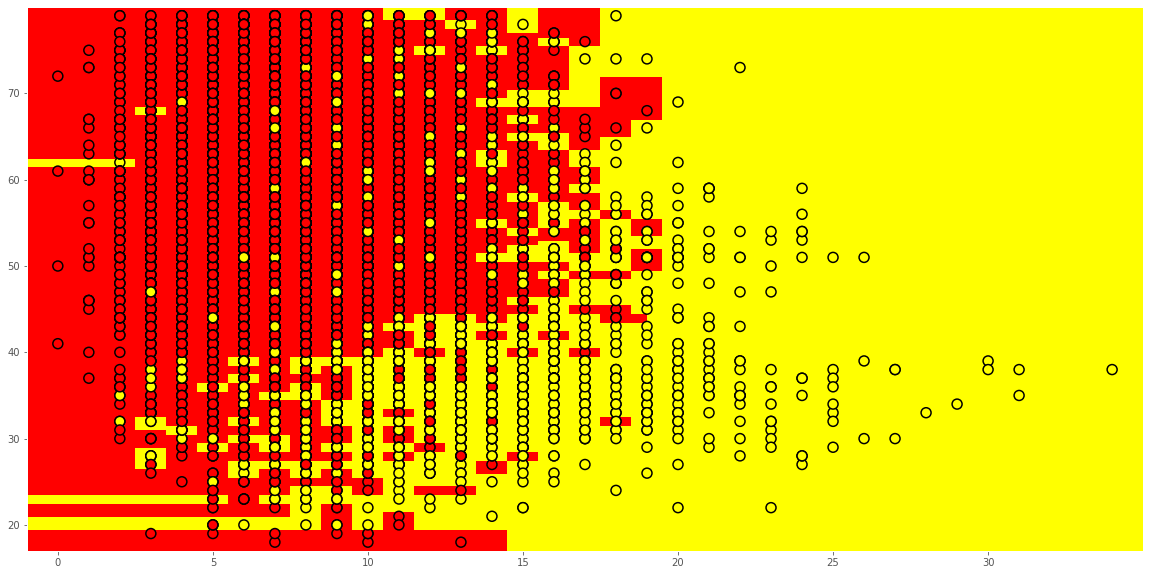

In [45]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=300, min_samples_leaf=1)
y_train_sur = y_train_sur.astype(int)
# обучаем дерево
tree.fit(X_train_sur, y_train_sur)
y_test_sur = y_test_sur.astype(int)

draw_dividing_surface(tree, X_train_sur, y_train_sur)
accuracy_score(y_test_sur, tree.predict(X_test_sur))

Оптимальное:

In [ ]:
tree2 = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=30)
y_train_sur = y_train_sur.astype(int)
y_test_sur = y_test_sur.astype(int)
# обучаем дерево
tree2.fit(X_train_sur, y_train_sur)

draw_dividing_surface(tree2, X_train_sur, y_train_sur)
accuracy_score(y_test_sur, tree.predict(X_test_sur))

0.7931603419829009

### 1c. Реализуйте бинарное кодирование категориальных признаков

In [ ]:
# df.drop([categorial_attr], axis='columns', inplace=False)
def bin_code(df, categorial_attr):
    for el in df[categorial_attr].unique():
        df[categorial_attr + '=' + el] = (df[categorial_attr] == el).astype(int)

In [ ]:
bin_code(organics_data, 'DemGender')
bin_code(organics_data, 'DemClusterGroup')
bin_code(organics_data, 'DemReg')
bin_code(organics_data, 'DemTVReg')
bin_code(organics_data, 'PromClass')

In [ ]:
organics_data.head()

In [ ]:
columns = ['DemGender','DemClusterGroup','DemReg','DemTVReg','PromClass']
organics_data.drop(columns, axis=1, inplace=True)

In [ ]:
organics_data.head()

In [ ]:
organics_data.columns

In [ ]:
new_x=organics_data[['DemAffl',  'DemAge', 'DemCluster', 'PromSpend', 'PromTime', 'DemGender=U', 'DemGender=F', 'DemGender=M',
       'DemClusterGroup=C', 'DemClusterGroup=D', 'DemClusterGroup=F',
       'DemClusterGroup=A', 'DemClusterGroup=B', 'DemClusterGroup=E',
       'DemClusterGroup=U', 'DemReg=Midlands', 'DemReg=North',
       'DemReg=South East', 'DemReg=Scottish', 'DemReg=South West',
       'DemTVReg=Wales & West', 'DemTVReg=Midlands', 'DemTVReg=N West',
       'DemTVReg=East', 'DemTVReg=N East', 'DemTVReg=London',
       'DemTVReg=S & S East', 'DemTVReg=C Scotland', 'DemTVReg=Ulster',
       'DemTVReg=S West', 'DemTVReg=Yorkshire', 'DemTVReg=Border',
       'DemTVReg=N Scot', 'PromClass=Gold', 'PromClass=Silver',
       'PromClass=Tin', 'PromClass=Platinum']]
new_y=organics_data.values[::,6]
new_y=new_y.astype('int')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_x, new_y, test_size=0.3)

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=30)
tree.fit(X_train, y_train)
tree.score(X_train, y_train), accuracy_score(y_test, tree.predict(X_test))

In [ ]:
dotfile = open(r'Organics_tree_with_categ.dot', 'w')

graph = Source(export_graphviz(tree, out_file=dotfile, 
               rounded = True, proportion = False, 
                precision = 2, filled = True))
dotfile.close()
system("dot -Tpng Organics_tree_with_categ.dot -o Organics_tree_with_categ.png")